In [384]:
from os import rename
from os.path import split, join
from glob import glob
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import product
from IPython.display import display, HTML
pd.options.display.max_columns = 100
pd.options.display.max_rows = 10
sns.set_context("paper", font_scale=1.4)

# FHHPS Empirical Application

---

---

Reading data in (ignore).

In [396]:
dfs = []
for k, file in enumerate(glob(join("empirical_out", "*"))):
    df_tmp = pd.read_csv(file, header=None)
    dfs.append(df_tmp)
    
df = pd.concat(dfs).dropna()

In [397]:
mean_names = ["EA", "EB", "EC"]
cov_names = ["VarA", "VarB", "VarC", "CovAB", "CovAC", "CovBC"]
param_names = ["shock_bw1_const", "output_bw1_coqnst_step1", "output_bw1_const_step2", "output_bw2_const"]
pretty_param_names = ["$c_{shock}$", "$c_{y,1}^{(1)}$", "$c_{y,1}^{(2)}$", "$c_{y,2}$"]

In [398]:
params = ['n', 'kernel1', 'kernel2', 
      'output_bw1_const_step1', 'output_bw1_const_step2', 'output_bw2_const',
      'output_bw1_alpha', 'output_bw2_alpha', 
      'shock_bw1_const', 'shock_bw2_const', 'shock_bw1_alpha', 'shock_bw2_alpha', 
      'censor1_const', 'censor2_const']
others = ['mean_valid', 'cov_valid',"time"]
cols = params + others
df.columns = cols + mean_names + cov_names
df = df.drop_duplicates(params)

Number of unique parameter combinations

In [399]:
f"We tried {len(df)} different tuning parameter combinations"

'We tried 91914 different tuning parameter combinations'

In [400]:
df.head()

,n,kernel1,kernel2,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,censor1_const,censor2_const,mean_valid,cov_valid,time,EA,EB,EC,VarA,VarB,VarC,CovAB,CovAC,CovBC
0,2501,gaussian,gaussian,0.75,0.25,0.10,0.1,0.1,0.75,0.1,0.166667,0.166667,1.5,1.5,0.451819,0.055578,25.141415,0.985419,-0.023741,0.009764,6.727758e+06,32250.268114,822.416180,-469162.867752,74737.166589,-5177.213606
1,2501,neighbor,neighbor,0.75,0.10,0.25,0.1,0.1,0.25,1.0,0.166667,0.166667,1.5,1.0,0.451819,0.062775,23.314401,4.836907,-0.296089,-0.009239,-2.393513e+03,-2.774495,-2.610010,85.926687,62.777299,-1.961132
2,2501,gaussian,gaussian,0.10,1.00,0.50,0.1,0.1,0.50,0.5,0.166667,0.166667,1.0,1.0,0.550580,0.062775,20.970403,0.650364,-0.049692,0.058165,5.190798e+02,1.477454,0.874862,-23.958718,-4.807919,-0.435598
3,2501,gaussian,gaussian,1.00,0.10,0.25,0.1,0.1,1.00,0.1,0.166667,0.166667,1.0,0.5,0.550580,0.074770,20.694484,1.166950,-0.018846,-0.009699,6.131287e+03,24.548959,5.366953,-352.301503,-27.421778,-3.019102
4,2501,gaussian,neighbor,0.50,0.25,1.00,0.1,0.1,0.10,0.1,0.166667,0.166667,0.5,1.0,0.716114,0.062775,24.839138,2.387369,-0.091520,-0.037496,-6.290749e+02,4.172742,-2.227558,-15.618102,48.981569,-1.748640


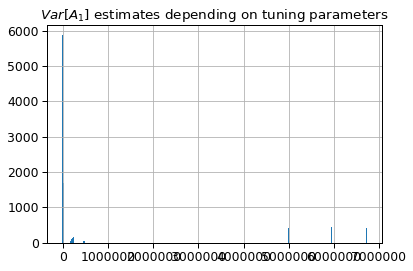

In [401]:
cond = (df["output_bw2_const"] < .5)  & (df["output_bw1_const_step2"] < .5)& (df["output_bw1_const_step1"] < .5)
ax = df[cond]["VarA"].hist(bins=300)
ax.set_title("$Var[A_{1}]$ estimates depending on tuning parameters");

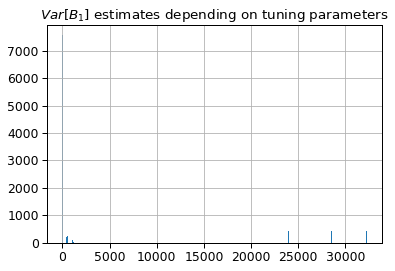

In [402]:
#cond = (df["output_bw2_const"] < 0.1) & (df["output_bw1_const_step2"] < 1)& (df["output_bw1_const_step1"] < 1)
ax = df[cond]["VarB"].hist(bins=300)
ax.set_title("$Var[B_{1}]$ estimates depending on tuning parameters");

In [403]:
df[cond & (df["VarB"] > 0)]

,n,kernel1,kernel2,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,censor1_const,censor2_const,mean_valid,cov_valid,time,EA,EB,EC,VarA,VarB,VarC,CovAB,CovAC,CovBC
9,2501,gaussian,gaussian,0.10,0.10,0.10,0.1,0.1,0.10,0.50,0.166667,0.166667,1.00,0.50,0.550580,0.074770,18.147410,0.932441,-0.075006,0.064728,5.033863e+03,20.376186,4.822719,-293.932424,-11.532713,-3.218915
40,2501,gaussian,neighbor,0.10,0.10,0.10,0.1,0.1,0.75,0.10,0.166667,0.166667,1.00,0.50,0.550580,0.074770,21.226330,2.146449,-0.086339,-0.004564,9.971866e+02,9.853506,-0.073529,-106.319926,23.424832,-1.441993
7,10566,gaussian,neighbor,0.01,0.10,0.05,0.1,0.1,0.01,0.50,0.166667,0.166667,0.50,0.01,0.831157,0.239163,293.358549,1.054229,-0.051660,0.014259,1.814253e+03,5.602738,0.487664,-93.034857,1.959647,-0.760703
8,10566,gaussian,neighbor,0.10,0.01,0.05,0.1,0.1,0.01,0.01,0.166667,0.166667,0.01,0.10,0.996025,0.143006,273.816187,4.239757,-0.334661,0.162387,1.688331e+02,1.051849,-1.582723,-27.947126,40.042483,-0.846863
32,2501,gaussian,gaussian,0.25,0.25,0.25,0.1,0.1,1.00,0.25,0.166667,0.166667,1.50,1.00,0.451819,0.062775,23.414246,27.656325,-1.904728,0.346041,5.961712e+06,28577.844164,728.855954,-415390.886481,66163.856779,-4583.745375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,10566,neighbor,neighbor,0.05,0.10,0.10,0.1,0.1,0.10,0.10,0.166667,0.166667,2.00,2.00,0.547700,0.061140,307.428802,1.156498,-0.036962,-0.005414,6.048681e+02,2.338600,-5.776415,-74.286590,46.479253,2.474079
14,10566,gaussian,neighbor,0.01,0.05,0.10,0.1,0.1,0.10,0.10,0.166667,0.166667,2.00,1.00,0.547700,0.075052,310.051594,0.249695,0.021742,-0.009228,9.592575e+01,2.808851,-7.109744,-74.050651,80.486504,1.664757
0,10566,neighbor,neighbor,0.01,0.01,0.10,0.1,0.1,0.10,0.10,0.166667,0.166667,1.00,0.01,0.706890,0.239163,292.240169,1.428188,-0.001766,-0.068737,7.859271e+03,13.843145,18.262010,-199.648371,-245.261326,-3.238983
59,2501,neighbor,neighbor,0.10,0.25,0.10,0.1,0.1,0.50,0.10,0.166667,0.166667,1.00,1.50,0.550580,0.055578,22.387764,3.010652,-0.215916,0.065329,2.986145e+03,19.885061,2.378419,-230.179975,-12.591862,-1.194385


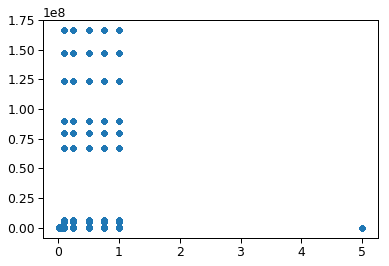

In [404]:
cond = (df["output_bw1_const_step2"] < 1) &(df["output_bw2_const"] < 1)
plt.scatter(df[cond]["shock_bw2_const"], df[cond]["VarA"])

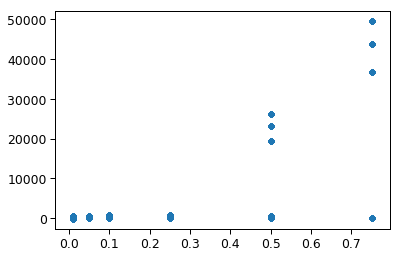

In [405]:

plt.scatter(df[cond]["output_bw2_const"], df[cond]["VarC"])

In [417]:
df_good = df[
    
    # Variances are positive
    (df["VarA"] > 0) & (df["VarB"] > 0)  & (df["VarC"] > 0) 
    
    # Variances have reasonable magnitude
    & (df["VarA"] < 50) & (np.abs(df["CovAB"]) < 20)  & (np.abs(df["CovAC"]) < 20) 

    # Correlations are smaller than 1
    & (np.abs(df["CovAC"]) < np.sqrt(df["VarA"]*df["VarC"]))
    & (np.abs(df["CovAB"]) < np.sqrt(df["VarA"]*df["VarB"]))
    & (np.abs(df["CovBC"]) < np.sqrt(df["VarB"]*df["VarC"]))
    
].drop_duplicates()

/Users/vitorh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


There are no observations satisfying all the criteria above

In [418]:
df_good.sort_values(by=["EA", "EB", "EC"])

,n,kernel1,kernel2,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,censor1_const,censor2_const,mean_valid,cov_valid,time,EA,EB,EC,VarA,VarB,VarC,CovAB,CovAC,CovBC
22,2501,gaussian,gaussian,0.10,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,1.5,0.5,0.451819,0.07477,23.023035,0.420905,-0.081227,0.105117,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
0,2501,gaussian,gaussian,0.10,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,1.0,0.5,0.550580,0.07477,26.994536,0.738527,-0.056777,0.059492,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
65,2501,gaussian,gaussian,1.00,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,1.5,0.5,0.451819,0.07477,19.577769,1.272406,-0.036109,0.000985,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
18,2501,gaussian,gaussian,1.00,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,1.0,0.5,0.550580,0.07477,20.429560,1.307912,-0.030484,-0.007320,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
38,2501,gaussian,gaussian,0.50,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,0.5,0.5,0.716114,0.07477,21.394878,18.571948,-1.196868,0.160951,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
6,2501,gaussian,gaussian,0.25,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,0.5,0.5,0.716114,0.07477,20.436366,18.605404,-1.189694,0.150528,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
26,2501,gaussian,gaussian,0.25,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,1.0,0.5,0.550580,0.07477,20.059132,23.150506,-1.568434,0.267276,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
25,2501,gaussian,gaussian,0.25,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,1.5,0.5,0.451819,0.07477,23.303753,27.803168,-1.916174,0.347799,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
82,2501,gaussian,gaussian,0.50,0.75,0.75,0.1,0.1,0.25,0.1,0.166667,0.166667,1.5,0.5,0.451819,0.07477,19.523761,28.218479,-1.917866,0.319755,49.474183,0.760835,0.531906,-4.745937,-4.299,-0.175283
